In [65]:
from collections import defaultdict
import time
from statistics import mean

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from data import classification_dataset, train_test_split, kfolds
from layers import SeluConv3D, SeluDense
from callbacks import TimeEpoch
from plot import plot_slice, plot_volume_animation, plot_loss_history
from config import (
    LIDC_SMALL_NEG_TFRECORD,
    LIDC_BIG_NEG_TFRECORD,
    LIDC_SMALL_POS_TFRECORD,
    LIDC_BIG_POS_TFRECORD,
    SPIE_SMALL_NEG_TFRECORD,
    SPIE_BIG_NEG_TFRECORD,
    SPIE_SMALL_POS_TFRECORD,
    SPIE_BIG_POS_TFRECORD,
    SMALL_PATCH_SHAPE,
    BIG_PATCH_SHAPE,
)

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
lidc_dataset, lidc_samples = classification_dataset(
    LIDC_SMALL_NEG_TFRECORD,
    LIDC_BIG_NEG_TFRECORD,
    LIDC_SMALL_POS_TFRECORD,
    LIDC_BIG_POS_TFRECORD,
    return_size=True,
)
print(f"{lidc_samples = }")
lidc_dataset

lidc_samples = 754


<ShuffleDataset shapes: (((None, None, None, None), (None, None, None, None)), (1,)), types: ((tf.float32, tf.float32), tf.int8)>

In [4]:
def build_3d_cnn():
    input_small = keras.Input(SMALL_PATCH_SHAPE, name="input_small")
    x_small = SeluConv3D(
        filters=32,
        kernel_size=3,
        name="small_selu_conv3d_1",
    )(input_small)
    x_small = keras.layers.MaxPool3D((1, 2, 2), name="small_maxpool_1")(x_small)
    x_small = SeluConv3D(
        filters=64,
        kernel_size=3,
        name="small_selu_conv3d_2",
    )(x_small)
    x_small = keras.layers.MaxPool3D((1, 2, 2), name="small_maxpool_2")(x_small)
    x_small = SeluConv3D(
        filters=128,
        kernel_size=3,
        name="small_selu_conv3d_3",
    )(x_small)
    x_small = keras.layers.MaxPool3D((1, 2, 2), name="small_maxpool_3")(x_small)
    x_small = SeluConv3D(
        filters=256,
        kernel_size=3,
        name="small_selu_conv3d_4",
    )(x_small)
    x_small = keras.layers.MaxPool3D((1, 2, 2), name="small_maxpool_4")(x_small)
    x_small = keras.layers.Flatten(name="flatten_small")(x_small)

    input_big = keras.Input(BIG_PATCH_SHAPE, name="input_big")
    x_big = keras.layers.MaxPool3D((2, 2, 2), name="big_maxpool_0")(input_big)
    x_big = SeluConv3D(
        filters=32,
        kernel_size=3,
        name="big_selu_conv3d_1",
    )(x_big)
    x_big = keras.layers.MaxPool3D((1, 2, 2), name="big_maxpool_1")(x_big)
    x_big = SeluConv3D(
        filters=64,
        kernel_size=3,
        name="big_selu_conv3d_2",
    )(x_big)
    x_big = keras.layers.MaxPool3D((1, 2, 2), name="big_maxpool_2")(x_big)
    x_big = SeluConv3D(
        filters=128,
        kernel_size=3,
        name="big_selu_conv3d_3",
    )(x_big)
    x_big = keras.layers.MaxPool3D((1, 2, 2), name="big_maxpool_3")(x_big)
    x_big = SeluConv3D(
        filters=256,
        kernel_size=3,
        name="big_selu_conv3d_4",
    )(x_big)
    x_big = keras.layers.MaxPool3D((1, 2, 2), name="big_maxpool_4")(x_big)
    x_big = keras.layers.Flatten(name="flatten_big")(x_big)

    x = keras.layers.concatenate([x_small, x_big], name="concatenate")
    x = keras.layers.Dense(1, activation="sigmoid", name="final_dense")(x)

    cnn_3d = keras.Model(inputs=[input_small, input_big], outputs=x, name="3dcnn")

    return cnn_3d

In [5]:
learning_rate = 1e-5
val_perc = 0.2
patience = 20
batch_size = 16
metrics = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]

In [6]:
train_dataset, val_dataset = train_test_split(lidc_dataset, test_perc=val_perc)
val_dataset = val_dataset.batch(batch_size)
train_dataset = (
    train_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [7]:
cnn = build_3d_cnn()
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics,
)
time_callback = TimeEpoch()
history = cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,
    verbose=1,
    callbacks=[
        time_callback,
        keras.callbacks.ModelCheckpoint(
            "models/lidc-3d-cnn.h5",
            monitor="val_loss",
            save_best_only=True,
            verbose=1,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=patience,
            restore_best_weights=True,
        ),
    ],
)

Epoch 1/1000
     38/Unknown - 1s 18ms/step - loss: 0.6853 - tp: 198.0000 - fp: 172.0000 - tn: 129.0000 - fn: 105.0000 - precision: 0.5351 - recall: 0.6535 - auc: 0.5811 - accuracy: 0.5414
Epoch 00001: val_loss improved from inf to 0.62920, saving model to models/lidc-3d-cnn.h5
38/38 [==============================] - 2s 52ms/step - loss: 0.6853 - tp: 198.0000 - fp: 172.0000 - tn: 129.0000 - fn: 105.0000 - precision: 0.5351 - recall: 0.6535 - auc: 0.5811 - accuracy: 0.5414 - val_loss: 0.6292 - val_tp: 46.0000 - val_fp: 19.0000 - val_tn: 55.0000 - val_fn: 30.0000 - val_precision: 0.7077 - val_recall: 0.6053 - val_auc: 0.7296 - val_accuracy: 0.6733
Epoch 2/1000
35/38 [==========================>...] - ETA: 0s - loss: 0.5840 - tp: 205.0000 - fp: 76.0000 - tn: 201.0000 - fn: 78.0000 - precision: 0.7295 - recall: 0.7244 - auc: 0.7950 - accuracy: 0.7250
Epoch 00002: val_loss improved from 0.62920 to 0.61725, saving model to models/lidc-3d-cnn.h5
38/38 [==============================] - 1s 30

Epoch 14/1000
36/38 [===========================>..] - ETA: 0s - loss: 0.3840 - tp: 251.0000 - fp: 42.0000 - tn: 245.0000 - fn: 38.0000 - precision: 0.8567 - recall: 0.8685 - auc: 0.9368 - accuracy: 0.8611
Epoch 00014: val_loss did not improve from 0.47390
38/38 [==============================] - 1s 26ms/step - loss: 0.3792 - tp: 263.0000 - fp: 43.0000 - tn: 258.0000 - fn: 40.0000 - precision: 0.8595 - recall: 0.8680 - auc: 0.9385 - accuracy: 0.8626 - val_loss: 0.5281 - val_tp: 40.0000 - val_fp: 2.0000 - val_tn: 72.0000 - val_fn: 36.0000 - val_precision: 0.9524 - val_recall: 0.5263 - val_auc: 0.8538 - val_accuracy: 0.7467
Epoch 15/1000
36/38 [===========================>..] - ETA: 0s - loss: 0.3859 - tp: 222.0000 - fp: 37.0000 - tn: 250.0000 - fn: 67.0000 - precision: 0.8571 - recall: 0.7682 - auc: 0.9281 - accuracy: 0.8194
Epoch 00015: val_loss did not improve from 0.47390
38/38 [==============================] - 1s 27ms/step - loss: 0.3867 - tp: 235.0000 - fp: 40.0000 - tn: 261.0000 

Epoch 27/1000
37/38 [============================>.] - ETA: 0s - loss: 0.2930 - tp: 254.0000 - fp: 17.0000 - tn: 279.0000 - fn: 42.0000 - precision: 0.9373 - recall: 0.8581 - auc: 0.9721 - accuracy: 0.9003
Epoch 00027: val_loss did not improve from 0.44170
38/38 [==============================] - 1s 26ms/step - loss: 0.2906 - tp: 261.0000 - fp: 17.0000 - tn: 284.0000 - fn: 42.0000 - precision: 0.9388 - recall: 0.8614 - auc: 0.9730 - accuracy: 0.9023 - val_loss: 0.4715 - val_tp: 63.0000 - val_fp: 18.0000 - val_tn: 56.0000 - val_fn: 13.0000 - val_precision: 0.7778 - val_recall: 0.8289 - val_auc: 0.8611 - val_accuracy: 0.7933
Epoch 28/1000
36/38 [===========================>..] - ETA: 0s - loss: 0.2850 - tp: 265.0000 - fp: 27.0000 - tn: 258.0000 - fn: 26.0000 - precision: 0.9075 - recall: 0.9107 - auc: 0.9763 - accuracy: 0.9080
Epoch 00028: val_loss did not improve from 0.44170
38/38 [==============================] - 1s 27ms/step - loss: 0.2813 - tp: 277.0000 - fp: 27.0000 - tn: 274.0000

Epoch 40/1000
37/38 [============================>.] - ETA: 0s - loss: 0.2229 - tp: 269.0000 - fp: 10.0000 - tn: 288.0000 - fn: 25.0000 - precision: 0.9642 - recall: 0.9150 - auc: 0.9912 - accuracy: 0.9409
Epoch 00040: val_loss did not improve from 0.43056
38/38 [==============================] - 1s 27ms/step - loss: 0.2220 - tp: 278.0000 - fp: 10.0000 - tn: 291.0000 - fn: 25.0000 - precision: 0.9653 - recall: 0.9175 - auc: 0.9915 - accuracy: 0.9421 - val_loss: 0.4812 - val_tp: 66.0000 - val_fp: 21.0000 - val_tn: 53.0000 - val_fn: 10.0000 - val_precision: 0.7586 - val_recall: 0.8684 - val_auc: 0.8628 - val_accuracy: 0.7933
Epoch 41/1000
35/38 [==========================>...] - ETA: 0s - loss: 0.2267 - tp: 266.0000 - fp: 19.0000 - tn: 259.0000 - fn: 16.0000 - precision: 0.9333 - recall: 0.9433 - auc: 0.9870 - accuracy: 0.9375
Epoch 00041: val_loss did not improve from 0.43056
38/38 [==============================] - 1s 27ms/step - loss: 0.2287 - tp: 283.0000 - fp: 19.0000 - tn: 282.0000

Epoch 53/1000
37/38 [============================>.] - ETA: 0s - loss: 0.1781 - tp: 287.0000 - fp: 10.0000 - tn: 285.0000 - fn: 10.0000 - precision: 0.9663 - recall: 0.9663 - auc: 0.9947 - accuracy: 0.9662
Epoch 00053: val_loss did not improve from 0.41877
38/38 [==============================] - 1s 27ms/step - loss: 0.1773 - tp: 293.0000 - fp: 10.0000 - tn: 291.0000 - fn: 10.0000 - precision: 0.9670 - recall: 0.9670 - auc: 0.9948 - accuracy: 0.9669 - val_loss: 0.4279 - val_tp: 51.0000 - val_fp: 11.0000 - val_tn: 63.0000 - val_fn: 25.0000 - val_precision: 0.8226 - val_recall: 0.6711 - val_auc: 0.8887 - val_accuracy: 0.7600
Epoch 54/1000
35/38 [==========================>...] - ETA: 0s - loss: 0.1813 - tp: 273.0000 - fp: 10.0000 - tn: 266.0000 - fn: 11.0000 - precision: 0.9647 - recall: 0.9613 - auc: 0.9952 - accuracy: 0.9625
Epoch 00054: val_loss improved from 0.41877 to 0.41628, saving model to models/lidc-3d-cnn.h5
38/38 [==============================] - 1s 28ms/step - loss: 0.1773 

Epoch 66/1000
35/38 [==========================>...] - ETA: 0s - loss: 0.1418 - tp: 279.0000 - fp: 3.0000 - tn: 273.0000 - fn: 5.0000 - precision: 0.9894 - recall: 0.9824 - auc: 0.9992 - accuracy: 0.9857
Epoch 00066: val_loss did not improve from 0.40710
38/38 [==============================] - 1s 26ms/step - loss: 0.1399 - tp: 298.0000 - fp: 4.0000 - tn: 297.0000 - fn: 5.0000 - precision: 0.9868 - recall: 0.9835 - auc: 0.9992 - accuracy: 0.9851 - val_loss: 0.4259 - val_tp: 50.0000 - val_fp: 10.0000 - val_tn: 64.0000 - val_fn: 26.0000 - val_precision: 0.8333 - val_recall: 0.6579 - val_auc: 0.8914 - val_accuracy: 0.7600
Epoch 67/1000
35/38 [==========================>...] - ETA: 0s - loss: 0.1415 - tp: 272.0000 - fp: 6.0000 - tn: 277.0000 - fn: 5.0000 - precision: 0.9784 - recall: 0.9819 - auc: 0.9982 - accuracy: 0.9804
Epoch 00067: val_loss did not improve from 0.40710
38/38 [==============================] - 1s 27ms/step - loss: 0.1404 - tp: 298.0000 - fp: 6.0000 - tn: 295.0000 - fn: 

35/38 [==========================>...] - ETA: 0s - loss: 0.1129 - tp: 277.0000 - fp: 2.0000 - tn: 278.0000 - fn: 3.0000 - precision: 0.9928 - recall: 0.9893 - auc: 0.9995 - accuracy: 0.9911
Epoch 00079: val_loss did not improve from 0.40710
38/38 [==============================] - 1s 27ms/step - loss: 0.1101 - tp: 300.0000 - fp: 3.0000 - tn: 298.0000 - fn: 3.0000 - precision: 0.9901 - recall: 0.9901 - auc: 0.9995 - accuracy: 0.9901 - val_loss: 0.4166 - val_tp: 64.0000 - val_fp: 18.0000 - val_tn: 56.0000 - val_fn: 12.0000 - val_precision: 0.7805 - val_recall: 0.8421 - val_auc: 0.8861 - val_accuracy: 0.8000
Epoch 80/1000
35/38 [==========================>...] - ETA: 0s - loss: 0.1079 - tp: 277.0000 - fp: 2.0000 - tn: 275.0000 - fn: 6.0000 - precision: 0.9928 - recall: 0.9788 - auc: 0.9996 - accuracy: 0.9857
Epoch 00080: val_loss did not improve from 0.40710
38/38 [==============================] - 1s 27ms/step - loss: 0.1097 - tp: 297.0000 - fp: 2.0000 - tn: 299.0000 - fn: 6.0000 - preci

In [8]:
cnn = keras.models.load_model("models/lidc-3d-cnn.h5")
cnn.evaluate(val_dataset, return_dict=True)

10/10 [==============================] - 0s 9ms/step - loss: 0.4071 - tp: 57.0000 - fp: 15.0000 - tn: 59.0000 - fn: 19.0000 - precision: 0.7917 - recall: 0.7500 - auc: 0.8928 - accuracy: 0.7733


{'loss': 0.4071008265018463,
 'tp': 57.0,
 'fp': 15.0,
 'tn': 59.0,
 'fn': 19.0,
 'precision': 0.7916666865348816,
 'recall': 0.75,
 'auc': 0.8927809000015259,
 'accuracy': 0.7733333110809326}

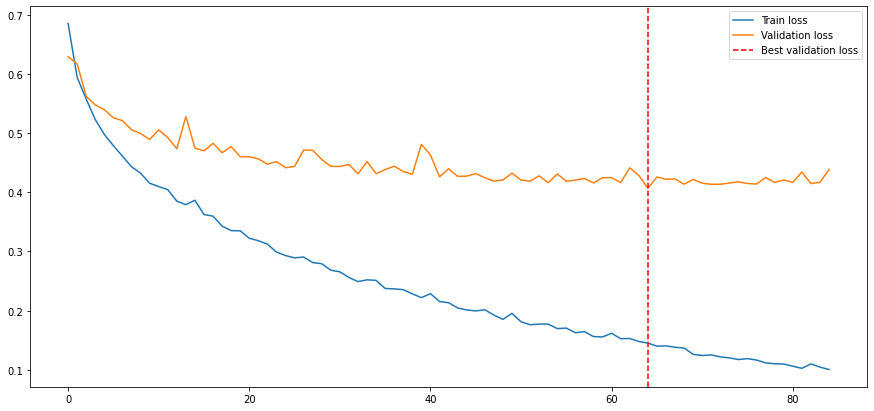

In [9]:
plot_loss_history(history)
plt.savefig("lidc-loss.pdf")

In [10]:
f"Mean time per epoch: {np.mean(time_callback.times):.2f}s"

'Mean time per epoch: 1.09s'

In [11]:
spie_dataset, spie_samples = classification_dataset(
    SPIE_SMALL_NEG_TFRECORD,
    SPIE_BIG_NEG_TFRECORD,
    SPIE_SMALL_POS_TFRECORD,
    SPIE_BIG_POS_TFRECORD,
    return_size=True,
)
print(f"{spie_samples = }")
spie_dataset

spie_samples = 73


<ShuffleDataset shapes: (((None, None, None, None), (None, None, None, None)), (1,)), types: ((tf.float32, tf.float32), tf.int8)>

In [16]:
def build_pretrained_3d_cnn(freeze_conv_layers=True):
    pretrained_3d_cnn = keras.models.load_model("models/lidc-3d-cnn.h5")
    if freeze_conv_layers:
        for layer in pretrained_3d_cnn.layers:
            if "conv" in layer.name:
                layer.trainable = False
    return pretrained_3d_cnn

In [124]:
# k = spie_samples  # LOOCV
k = 3
val_perc = 0.1
learning_rate = 1e-5
batch_size = 8
patience = 10
num_epochs = 1000

In [125]:
y_true = []

lidc_predictions = []
lidc_aucs = []
lidc_accs = []

wo_pt_histories = []
wo_pt_predictions = []
wo_pt_aucs = []
wo_pt_accs = []

w_pt_histories = []
w_pt_predictions = []
w_pt_aucs = []
w_pt_accs = []

for fold_id, (train_dataset, test_dataset) in tqdm(
    enumerate(kfolds(k, spie_dataset, cardinality=spie_samples)), total=k
):
    # print(f" {fold_id = } ".center(50, "="))
    for _, y in test_dataset.as_numpy_iterator():
        y_true.append(y[0])
    test_dataset = test_dataset.batch(1)
    train_dataset, val_dataset = train_test_split(train_dataset, test_perc=val_perc)
    val_dataset = val_dataset.batch(batch_size)
    train_dataset = (
        train_dataset.cache()  # must be called before shuffle
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .batch(batch_size)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

    cnn = keras.models.load_model("models/lidc-3d-cnn.h5")
    cnn.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.AUC(name="auc", num_thresholds=1000),
            keras.metrics.BinaryAccuracy(name="accuracy"),
        ],
    )
    test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=0)
    lidc_aucs.append(round(test_metrics["auc"], 2))
    lidc_accs.append(round(test_metrics["accuracy"], 2))
    for test_x, _ in test_dataset.as_numpy_iterator():
        pred_y = cnn(test_x, training=False)
        lidc_predictions.append(pred_y.numpy()[0][0])

    cnn = build_3d_cnn()
    cnn.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.AUC(name="auc", num_thresholds=1000),
            keras.metrics.BinaryAccuracy(name="accuracy"),
        ],
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=patience,
                restore_best_weights=True,
            )
        ],
    )
    wo_pt_histories.append(history)
    test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=0)
    wo_pt_aucs.append(round(test_metrics["auc"], 2))
    wo_pt_accs.append(round(test_metrics["accuracy"], 2))
    for test_x, _ in test_dataset.as_numpy_iterator():
        pred_y = cnn(test_x, training=False)
        wo_pt_predictions.append(pred_y.numpy()[0][0])

    cnn = build_pretrained_3d_cnn()
    cnn.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.AUC(name="auc", num_thresholds=1000),
            keras.metrics.BinaryAccuracy(name="accuracy"),
        ],
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=100,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=patience,
                restore_best_weights=True,
            )
        ],
    )
    w_pt_histories.append(history)
    test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=0)
    w_pt_aucs.append(round(test_metrics["auc"], 2))
    w_pt_accs.append(round(test_metrics["accuracy"], 2))
    for test_x, _ in test_dataset.as_numpy_iterator():
        pred_y = cnn(test_x, training=False)
        w_pt_predictions.append(pred_y.numpy()[0][0])

  0%|          | 0/3 [00:00<?, ?it/s]

In [127]:
print(f"{lidc_aucs = }")
print(f"{wo_pt_aucs = }")
print(f"{w_pt_aucs = }")
delta_auc = [
    round(w_pt_auc - wo_pt_auc, 2) for w_pt_auc, wo_pt_auc in zip(w_pt_aucs, wo_pt_aucs)
]
print(f"{delta_auc = }")
print(f"LIDC mean AUC: {mean(lidc_aucs)}")
print(f"W/O pre-training mean AUC: {mean(wo_pt_aucs)}")
print(f"W/ pre-training mean AUC: {mean(w_pt_aucs)}")
print("LIDC confusion matrix:")
print(f"{tf.math.confusion_matrix(y_true, [round(x, 0) for x in lidc_predictions])}")
print("")
print("W/O pre-training confusion matrix:")
print(f"{tf.math.confusion_matrix(y_true, [round(x, 0) for x in wo_pt_predictions])}")
print("")
print("W/ pre-training confusion matrix:")
print(f"{tf.math.confusion_matrix(y_true, [round(x, 0) for x in w_pt_predictions])}")
print("")

lidc_aucs = [0.67, 0.88, 0.5]
wo_pt_aucs = [0.44, 0.67, 0.62]
w_pt_aucs = [0.59, 0.9, 0.52]
delta_auc = [0.15, 0.23, -0.1]
LIDC mean AUC: 0.6833333333333333
W/O pre-training mean AUC: 0.5766666666666667
W/ pre-training mean AUC: 0.67
LIDC confusion matrix:
[[ 8 29]
 [ 1 35]]

W/O pre-training confusion matrix:
[[17 20]
 [14 22]]

W/ pre-training confusion matrix:
[[18 19]
 [13 23]]



In [122]:
index = 3
plt.plot(
    wo_pt_histories[index].history["loss"], "--", label="w/o pre-training - train loss"
)
plt.plot(
    wo_pt_histories[index].history["val_loss"], label="w/o pre-training - val loss"
)
plt.plot(
    w_pt_histories[index].history["loss"],
    "--",
    label="w/ pre-training, w/o conv freezing - train loss",
)
plt.plot(
    w_pt_histories[index].history["val_loss"],
    label="w/ pre-training, w/o conv freezing - val loss",
)
plt.legend()
# plot_loss_history(w_pt_conv_histories[0])

IndexError: list index out of range

In [ ]:
k = 10
val_perc = 0.1
learning_rate = 1e-5
batch_size = 8
num_epochs = 1000
metrics = [
    # keras.metrics.TruePositives(name="tp"),
    # keras.metrics.FalsePositives(name="fp"),
    # keras.metrics.TrueNegatives(name="tn"),
    # keras.metrics.FalseNegatives(name="fn"),
    # keras.metrics.Precision(name="precision"),
    # keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]

In [ ]:
lidc_mean_metrics = {
    f"{metric.name}": keras.metrics.Mean(name=f"mean_{metric.name}")
    for metric in metrics
}
wo_pt_histories = []
wo_pt_mean_metrics = {
    f"{metric.name}": keras.metrics.Mean(name=f"mean_{metric.name}")
    for metric in metrics
}
w_pt_histories = []
w_pt_mean_metrics = {
    f"{metric.name}": keras.metrics.Mean(name=f"mean_{metric.name}")
    for metric in metrics
}
w_pt_conv_histories = []
w_pt_conv_mean_metrics = {
    f"{metric.name}": keras.metrics.Mean(name=f"mean_{metric.name}")
    for metric in metrics
}
for fold_id, (train_dataset, test_dataset) in tqdm(
    enumerate(kfolds(k, spie_dataset, cardinality=spie_samples)), total=k
):
    print(f" {fold_id = } ".center(50, "="))

    test_dataset = test_dataset.batch(batch_size)
    train_dataset, val_dataset = train_test_split(train_dataset, test_perc=val_perc)
    val_dataset = val_dataset.batch(batch_size)
    train_dataset = (
        train_dataset.cache()  # must be called before shuffle
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .batch(batch_size)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    print(f"Train size: {sum(1 for _ in train_dataset.unbatch())}")
    print(f"Validation size: {sum(1 for _ in val_dataset.unbatch())}")
    print(f"Test size: {sum(1 for _ in test_dataset.unbatch())}")
    print()

    cnn = keras.models.load_model("models/lidc-3d-cnn.h5")
    cnn.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics,
    )
    test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=0)
    print("LIDC training only: ")
    for metric_name, metric_value in test_metrics.items():
        print(f"{metric_name}: {metric_value}")
        if metric_name in lidc_mean_metrics:
            lidc_mean_metrics[metric_name].update_state(metric_value)
    print("")

    cnn = build_3d_cnn()
    cnn.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics,
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=1000,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=20,
                restore_best_weights=True,
            )
        ],
    )
    wo_pt_histories.append(history)
    test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=0)
    print("Without pretraining: ")
    for metric_name, metric_value in test_metrics.items():
        print(f"{metric_name}: {metric_value}")
        if metric_name in wo_pt_mean_metrics:
            wo_pt_mean_metrics[metric_name].update_state(metric_value)
    print("")

    cnn = build_pretrained_3d_cnn(False)
    cnn.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics,
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=1000,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=20,
                restore_best_weights=True,
            )
        ],
    )
    w_pt_histories.append(history)
    test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=0)
    print("With pretraining (w/o conv freezing): ")
    for metric_name, metric_value in test_metrics.items():
        print(f"{metric_name}: {metric_value}")
        if metric_name in w_pt_mean_metrics:
            w_pt_mean_metrics[metric_name].update_state(metric_value)
    print("")

    cnn = build_pretrained_3d_cnn(True)
    cnn.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics,
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=1000,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=20,
                restore_best_weights=True,
            )
        ],
    )
    w_pt_conv_histories.append(history)
    test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=0)
    print("With pretraining (w/ conv freezing): ")
    for metric_name, metric_value in test_metrics.items():
        print(f"{metric_name}: {metric_value}")
        if metric_name in w_pt_conv_mean_metrics:
            w_pt_conv_mean_metrics[metric_name].update_state(metric_value)

print(" average ".center(50, "="))
print("LIDC training only: ")
for metric_name, metric_value in lidc_mean_metrics.items():
    print(f"{metric_name}: {metric_value.result()}")
print("")
print("Without pretraining: ")
for metric_name, metric_value in wo_pt_mean_metrics.items():
    print(f"{metric_name}: {metric_value.result()}")
print("")

print("With pretraining (w/o conv freezing): ")
for metric_name, metric_value in w_pt_mean_metrics.items():
    print(f"{metric_name}: {metric_value.result()}")
print("")

print("With pretraining (w/ conv freezing): ")
for metric_name, metric_value in w_pt_conv_mean_metrics.items():
    print(f"{metric_name}: {metric_value.result()}")

In [ ]:
histories = w_pt_conv_histories
_, ax = plt.subplots(nrows=2, ncols=2)
plot_loss_history(histories[0], ax[0][0])
# ax[0][0].set_title("Training=[k_2, k_3, k_4]; Test=[k_1]")
plot_loss_history(histories[1], ax[0][1])
# ax[0][1].set_title("Training=[k_1, k_3, k_4]; Test=[k_2]")
plot_loss_history(histories[2], ax[1][0])
# ax[0][1].set_title("Training=[k_1, k_2, k_4]; Test=[k_3]")
plot_loss_history(histories[3], ax[1][1])
# ax[0][1].set_title("Training=[k_1, k_2, k_3]; Test=[k_4]");
plt.savefig("w-pt-conv-losses.pdf")